In [1]:
# dataset
from torchvision import datasets

from functools import partial
import numpy as np

# visualization
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

# preprocessing
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torch.utils.data import random_split

# model
import torch
from torch import nn
import torchvision.models as models
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau

# hyperparameter tuning
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler

# metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

# 1. Load Data & Preprocessing

**Dataset**: <a href="https://www.cs.toronto.edu/~kriz/cifar.html" target="_blank">CIFAR-10</a>

**Classes**: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck

The following transformations are tested:
* **resize**
* **center crop**
* **normalization**: from [0, 255] to [0, 1]
* **standardization**: by substracting the mean and dividing with std according to ImageNet

In [2]:
def load_data(data_dir):
    """ Create train and test pytorch dataset objects from CIFAR-10.
    
    The following tranformations are applied on CIFAR-10:
        * resize images,
        * center crop images,
        * normalization: from [0, 255] to [0, 1] by dividing with 255,
        * standardization: by substracting the mean and dividing with std according to ImageNet
    
    Args:
        data_dir:
            directory where data will be saved, as a string.
    
    Returns:
        train and test dataset, as pytorch dataset objects.
    """
    transform = transforms.Compose([
        transforms.Resize(224), 
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    trainset = datasets.CIFAR10(root=data_dir,
                                train=True, 
                                download=True, 
                                transform=transform)

    testset = datasets.CIFAR10(root=data_dir, 
                               train=False, 
                               download=True, 
                               transform=transform)

    return trainset, testset

In [3]:
trainset, testset = load_data(data_dir='cifar10-pytorch')

print(f'\nTraining data:\n--------------\n{trainset}')
print(f'Test data:\n--------------\n{testset}')

Files already downloaded and verified
Files already downloaded and verified

Training data:
--------------
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: cifar10-pytorch
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=224, interpolation=bilinear, max_size=None, antialias=None)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
Test data:
--------------
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: cifar10-pytorch
    Split: Test
    StandardTransform
Transform: Compose(
               Resize(size=224, interpolation=bilinear, max_size=None, antialias=None)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )


In [4]:
batch_size = 64

train_dataloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

# 2. AlexNet

We'll use the **pretrained version** of AlexNet. Since CIFAR-10 dataset has less classes than ImageNet, we'll keep all the layers **freezed**, except of the last one, which will be **unfreezed** and updated with the right number of classes and will be re-trained.

![AlexNet](images\alexnet.png)

Regularization:
* Weight decay (L2 regularization)

Loss Function:
* Cross Entropy Loss

Optimizer and Scheduler:
* Adam optimizer
* ReduceLROnPlateau scheduler

In [5]:
def set_parameter_requires_grad(model, feature_extracting):
    """ This helper function sets the .requires_grad attribute of the parameters in the model 
    to False when we are feature extracting. 
    
    When we are feature extracting and only want to compute gradients for the newly initialized layer, 
    then we want all of the other parameters to not require gradients.
    
    Args:
        model: 
            deep learning model, as pytorch object.
        feature_extracting:
            whether or not we're feature extracting, as boolean.
    """
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [6]:
def initialize_model(num_labels, feature_extracting, pretrained=True):
    """ Initialize AlexNet model and reshape the last layer with the correct number of classes.
    
    Since AlexNet has been pretrained on Imagenet, it has output layers of size 1000, one node for each class. 
    We reshape the last layer to have the same number of inputs as before, and to have the same number of 
    outputs as the number of classes in our the dataset.
    
    Args:
        num_labels:
            number of labels in our dataset, as integer.
        feature_extracting:
          flag for feature extracting (when False, we finetune the whole model, 
          when True we only update the reshaped layer params), as boolean.
        pretrained:
            whether or not we want the pretrained version of AlexNet, as boolean.
    
    Returns:
        AlexNet model, as pytorch object
    """
    model = models.alexnet(pretrained=pretrained)
    
    set_parameter_requires_grad(model, feature_extracting)
    
    last_layer_in_ftrs = model.classifier[6].in_features
    model.classifier[6] = nn.Linear(last_layer_in_ftrs, num_labels)
    
    return model

# 3. Hyperparameter Tuning

We'll use **early stopping** with **ASHAScheduler** to stop bad trials earlier.

|                               | Validation Loss | Validation Accuracy |
| :---------------------------: | :-------------: | :-----------------: |
| AlexNet                       | 0.44            | 84%                 |

Best trial **configuration** for AlexNet: lr: 0.0001, l2: 0.0001

In [7]:
def tune_helper(config, trainset, num_labels, batch_size, epochs):
    """ Fit deep learning model and test it on a hold-out validation set.
    
    The validation set is a 20% hold-out set of the training set. 
    The loss function used is Cross Entropy Loss.
    The optimer used is Adam and the scheduler that wraps the optimizer is ReduceLROnPlateau.
    The metric used is accuracy score.
    
    Args:
        config:
            hyperparameters of neural network, as a dictionary.
        trainset:
            training dataset, as a pytorch object.
        num_labels:
            number of labels, as an integer.
        batch_size:
            size of batches to be processed, as an integer.
        epochs:
            number of epochs (times the neural network will see the data), as an integer.
    """
    feature_extracting = True
    pretrained = True
    model = initialize_model(num_labels=num_labels, 
                             feature_extracting=feature_extracting, 
                             pretrained=pretrained)
    
    # support data parallel training on multiple GPUs
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if torch.cuda.device_count() > 1:
            model = nn.DataParallel(model)
    model.to(device)
    
    # create an optimizer that only updates the desired parameters
    params_to_update = model.parameters()
    print("Parameters to learn:")
    if feature_extracting:
        params_to_update = []
        for name, param in model.named_parameters():
            if param.requires_grad == True:
                params_to_update.append(param)
                print("\t", name)
    else:
        for name, param in model.named_parameters():
            if param.requires_grad == True:
                print("\t", name)
    
    # optimizer
    optimizer = AdamW(params_to_update, lr=config['lr'], weight_decay=config['l2'])
    
    #scheduler
    scheduler = ReduceLROnPlateau(optimizer, mode='min')
    
    
    # loss function
    loss_fn = nn.CrossEntropyLoss()
    
    # split data: training (80%) - validation (20%)
    test_abs = int(len(trainset) * 0.8)
    train_subset, val_subset = random_split(trainset, [test_abs, len(trainset) - test_abs])

    train_dataloader = DataLoader(train_subset,
                                  batch_size=batch_size,
                                  shuffle=True, 
                                  num_workers=2)
    
    val_dataloader = DataLoader(val_subset,
                                batch_size=batch_size,
                                shuffle=True,
                                num_workers=2)
    
    for epoch in range(epochs):
        # fit neural network on training data
        model.train()  # put on train mode
        for batch, (X, Y) in enumerate(train_dataloader, 0):
            # send the data to the GPU memory explicitly
            X, Y = X.to(device), Y.to(device)

            # reset the gradients
            optimizer.zero_grad()
            
            # compute prediction
            pred = model(X)

            # compute loss
            loss = loss_fn(pred, Y)

            # backpropagate
            loss.backward()

            # update parameters
            optimizer.step()
        
        # test on validation data
        val_loss = 0.0
        val_steps = 0
        total = 0
        correct = 0
        model.eval()  # put on evaluation mode
        for batch, (X, Y) in enumerate(val_dataloader, 0):
            with torch.no_grad():
                X, Y = X.to(device), Y.to(device)

                pred = model(X)
                
                _, predicted = torch.max(pred.data, 1)
                total += Y.size(0)
                correct += (predicted == Y).sum().item()

                loss = loss_fn(pred, Y)
                val_loss += loss.cpu().numpy()
                val_steps += 1
        
        # update scheduler
        scheduler.step(val_loss)
        
        # report metrics
        tune.report(loss=(val_loss / val_steps), accuracy=(correct / total))

In [8]:
def hyperparameter_tune(data_dir,
                        batch_size,
                        epochs,
                        config,
                        grace_period,
                        num_samples, 
                        cpus_per_trial,
                        gpus_per_trial):
    """ Run hyperparameter tuning and report best hyperparameters.
    
    Args:
        data_dir:
            directory where CIFAR-10 data will be saved/loaded, as a string.
        batch_size:
            size of batches to be processed, as an integer.
        epochs:
            number of epochs (times the neural network will see the data), as an integer.
        config:
            hyperparametes, as a dictionary.
        grace_period:
            stop trials at least this old in time, as an integer.
        num_samples:
            number of times to sample from the hyperparameter space (if grid_search is provided as an argument,
            the grid will be repeated num_samples of times), as an integer.
        cpus_per_trial:
            CPUs to allocate per trial, as integer.
        gpus_per_trial:
            GPUs to allocate per trial, as integer.
    """
    trainset, testset = load_data(data_dir=data_dir)
    
    num_labels = 10
    
    # hyperparameter search space
    cofig = config
    
    # used for early stopping
    scheduler = ASHAScheduler(metric="loss", 
                              mode="min",
                              max_t=epochs,
                              grace_period=grace_period,
                              reduction_factor=2)
    
    reporter = CLIReporter(metric_columns=["loss", "accuracy", "training_iteration"])
    
    # hyperparamet tuning
    result = tune.run(tune.with_parameters(tune_helper,
                                           trainset=trainset,
                                           num_labels=num_labels,
                                           batch_size=batch_size,
                                           epochs=epochs),
                      resources_per_trial={"cpu": cpus_per_trial, "gpu": gpus_per_trial},
                      config=config,
                      num_samples=num_samples,
                      scheduler=scheduler,
                      progress_reporter=reporter)
    
    # report best results
    best_trial = result.get_best_trial("loss", "min", "last")
    print("Best trial config: {}".format(best_trial.config))
    print("Best trial final validation loss: {}".format(best_trial.last_result["loss"]))
    print("Best trial final validation acurracy: {}".format(best_trial.last_result["accuracy"]))

In [9]:
# hyperparameter search space
config = {
    "lr": tune.grid_search([1e-3, 1e-4]),
    "l2": tune.grid_search([1e-3, 1e-4])
    }

In [10]:
hyperparameter_tune(data_dir='cifar10-pytorch',
                    batch_size=64,
                    epochs=100,
                    config=config,
                    grace_period=10,
                    num_samples=1, 
                    cpus_per_trial=0,
                    gpus_per_trial=1)

Files already downloaded and verified
Files already downloaded and verified


2021-08-29 12:04:10,870	INFO services.py:1247 -- View the Ray dashboard at http://127.0.0.1:8265
2021-08-29 12:04:25,531	WARNING function_runner.py:545 -- Function checkpointing is disabled. This may result in unexpected behavior when using checkpointing features or certain schedulers. To enable, set the train function arguments to be `func(config, checkpoint_dir=None)`.
2021-08-29 12:04:26,844	ERROR syncer.py:72 -- Log sync requires rsync to be installed.


== Status ==
Memory usage on this node: 5.7/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 0/8 CPUs, 0/1 GPUs, 0.0/1.82 GiB heap, 0.0/0.91 GiB objects
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-08-29_12-04-25
Number of trials: 4/4 (4 PENDING)
+-------------------------+----------+-------+--------+--------+
| Trial name              | status   | loc   |     l2 |     lr |
|-------------------------+----------+-------+--------+--------|
| tune_helper_1bcda_00000 | PENDING  |       | 0.001  | 0.001  |
| tune_helper_1bcda_00001 | PENDING  |       | 0.0001 | 0.001  |
| tune_helper_1bcda_00002 | PENDING  |       | 0.001  | 0.0001 |
| tune_helper_1bcda_00003 | PENDING  |       | 0.0001 | 0.0001 |
+-------------------------+----------+-------+--------+--------+


== Status ==
Memory usage on this node: 5.7/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None

(pid=11556) C:\Users\lampr\anaconda3\envs\cbir-dl\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
(pid=11556)   return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Result for tune_helper_1bcda_00000:
  accuracy: 0.8071
  date: 2021-08-29_12-07-39
  done: false
  experiment_id: 43666fb897e44a1fabf896858562ad71
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 1
  loss: 0.5508980388474313
  node_ip: 192.168.1.18
  pid: 11556
  time_since_restore: 183.7912712097168
  time_this_iter_s: 183.7912712097168
  time_total_s: 183.7912712097168
  timestamp: 1630228059
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 1bcda_00000
  
== Status ==
Memory usage on this node: 6.6/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.82 GiB heap, 0.0/0.91 GiB objects (0.0/1.0 GPU_group_0_b4dbaddf2b4d22dc5face1ac8e3ac203, 0.0/1.0 GPU_group_b4dbaddf2b4d22dc5face1ac8e3ac203)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-08-29_12-04-25
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+-------------------------+----

Result for tune_helper_1bcda_00000:
  accuracy: 0.8139
  date: 2021-08-29_12-15-13
  done: false
  experiment_id: 43666fb897e44a1fabf896858562ad71
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 6
  loss: 0.5670889819123942
  node_ip: 192.168.1.18
  pid: 11556
  time_since_restore: 637.7219154834747
  time_this_iter_s: 87.14441752433777
  time_total_s: 637.7219154834747
  timestamp: 1630228513
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 1bcda_00000
  
== Status ==
Memory usage on this node: 6.1/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.82 GiB heap, 0.0/0.91 GiB objects (0.0/1.0 GPU_group_b4dbaddf2b4d22dc5face1ac8e3ac203, 0.0/1.0 GPU_group_0_b4dbaddf2b4d22dc5face1ac8e3ac203)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-08-29_12-04-25
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+-------------------------+----

Result for tune_helper_1bcda_00000:
  accuracy: 0.822
  date: 2021-08-29_12-22-27
  done: false
  experiment_id: 43666fb897e44a1fabf896858562ad71
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 11
  loss: 0.5391412678228062
  node_ip: 192.168.1.18
  pid: 11556
  time_since_restore: 1071.4041912555695
  time_this_iter_s: 80.21080708503723
  time_total_s: 1071.4041912555695
  timestamp: 1630228947
  timesteps_since_restore: 0
  training_iteration: 11
  trial_id: 1bcda_00000
  
== Status ==
Memory usage on this node: 6.0/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: -0.5332827418093469
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.82 GiB heap, 0.0/0.91 GiB objects (0.0/1.0 GPU_group_b4dbaddf2b4d22dc5face1ac8e3ac203, 0.0/1.0 GPU_group_0_b4dbaddf2b4d22dc5face1ac8e3ac203)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-08-29_12-04-25
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------

Result for tune_helper_1bcda_00000:
  accuracy: 0.8389
  date: 2021-08-29_12-29-57
  done: false
  experiment_id: 43666fb897e44a1fabf896858562ad71
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 16
  loss: 0.48561123469073303
  node_ip: 192.168.1.18
  pid: 11556
  time_since_restore: 1521.0188641548157
  time_this_iter_s: 96.82150840759277
  time_total_s: 1521.0188641548157
  timestamp: 1630229397
  timesteps_since_restore: 0
  training_iteration: 16
  trial_id: 1bcda_00000
  
== Status ==
Memory usage on this node: 5.9/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: -0.5332827418093469
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.82 GiB heap, 0.0/0.91 GiB objects (0.0/1.0 GPU_group_0_b4dbaddf2b4d22dc5face1ac8e3ac203, 0.0/1.0 GPU_group_b4dbaddf2b4d22dc5face1ac8e3ac203)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-08-29_12-04-25
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+----------

Result for tune_helper_1bcda_00000:
  accuracy: 0.8382
  date: 2021-08-29_12-36-40
  done: false
  experiment_id: 43666fb897e44a1fabf896858562ad71
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 21
  loss: 0.4753174347103022
  node_ip: 192.168.1.18
  pid: 11556
  time_since_restore: 1924.1962733268738
  time_this_iter_s: 78.89353013038635
  time_total_s: 1924.1962733268738
  timestamp: 1630229800
  timesteps_since_restore: 0
  training_iteration: 21
  trial_id: 1bcda_00000
  
== Status ==
Memory usage on this node: 5.5/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: -0.47314626011689 | Iter 10.000: -0.5332827418093469
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.82 GiB heap, 0.0/0.91 GiB objects (0.0/1.0 GPU_group_0_b4dbaddf2b4d22dc5face1ac8e3ac203, 0.0/1.0 GPU_group_b4dbaddf2b4d22dc5face1ac8e3ac203)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-08-29_12-04-25
Number of trials: 4/4 (3 PENDING, 1 RUNNING)

Result for tune_helper_1bcda_00000:
  accuracy: 0.8401
  date: 2021-08-29_12-44-11
  done: false
  experiment_id: 43666fb897e44a1fabf896858562ad71
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 26
  loss: 0.4714553598195884
  node_ip: 192.168.1.18
  pid: 11556
  time_since_restore: 2375.0992834568024
  time_this_iter_s: 111.4822895526886
  time_total_s: 2375.0992834568024
  timestamp: 1630230251
  timesteps_since_restore: 0
  training_iteration: 26
  trial_id: 1bcda_00000
  
== Status ==
Memory usage on this node: 5.3/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: -0.47314626011689 | Iter 10.000: -0.5332827418093469
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.82 GiB heap, 0.0/0.91 GiB objects (0.0/1.0 GPU_group_0_b4dbaddf2b4d22dc5face1ac8e3ac203, 0.0/1.0 GPU_group_b4dbaddf2b4d22dc5face1ac8e3ac203)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-08-29_12-04-25
Number of trials: 4/4 (3 PENDING, 1 RUNNING)

Result for tune_helper_1bcda_00000:
  accuracy: 0.8372
  date: 2021-08-29_12-51-24
  done: false
  experiment_id: 43666fb897e44a1fabf896858562ad71
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 31
  loss: 0.4759379677521955
  node_ip: 192.168.1.18
  pid: 11556
  time_since_restore: 2808.499899625778
  time_this_iter_s: 75.90277647972107
  time_total_s: 2808.499899625778
  timestamp: 1630230684
  timesteps_since_restore: 0
  training_iteration: 31
  trial_id: 1bcda_00000
  
== Status ==
Memory usage on this node: 5.2/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: -0.47314626011689 | Iter 10.000: -0.5332827418093469
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.82 GiB heap, 0.0/0.91 GiB objects (0.0/1.0 GPU_group_0_b4dbaddf2b4d22dc5face1ac8e3ac203, 0.0/1.0 GPU_group_b4dbaddf2b4d22dc5face1ac8e3ac203)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-08-29_12-04-25
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+

Result for tune_helper_1bcda_00000:
  accuracy: 0.8408
  date: 2021-08-29_12-57-44
  done: false
  experiment_id: 43666fb897e44a1fabf896858562ad71
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 36
  loss: 0.46630390472472855
  node_ip: 192.168.1.18
  pid: 11556
  time_since_restore: 3188.202304124832
  time_this_iter_s: 75.17084336280823
  time_total_s: 3188.202304124832
  timestamp: 1630231064
  timesteps_since_restore: 0
  training_iteration: 36
  trial_id: 1bcda_00000
  
== Status ==
Memory usage on this node: 5.1/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: -0.47314626011689 | Iter 10.000: -0.5332827418093469
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.82 GiB heap, 0.0/0.91 GiB objects (0.0/1.0 GPU_group_0_b4dbaddf2b4d22dc5face1ac8e3ac203, 0.0/1.0 GPU_group_b4dbaddf2b4d22dc5face1ac8e3ac203)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-08-29_12-04-25
Number of trials: 4/4 (3 PENDING, 1 RUNNING)


Result for tune_helper_1bcda_00000:
  accuracy: 0.84
  date: 2021-08-29_13-04-18
  done: false
  experiment_id: 43666fb897e44a1fabf896858562ad71
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 41
  loss: 0.4640060110836272
  node_ip: 192.168.1.18
  pid: 11556
  time_since_restore: 3582.729397058487
  time_this_iter_s: 79.24850988388062
  time_total_s: 3582.729397058487
  timestamp: 1630231458
  timesteps_since_restore: 0
  training_iteration: 41
  trial_id: 1bcda_00000
  
== Status ==
Memory usage on this node: 5.3/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: -0.4693321281937277 | Iter 20.000: -0.47314626011689 | Iter 10.000: -0.5332827418093469
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.82 GiB heap, 0.0/0.91 GiB objects (0.0/1.0 GPU_group_0_b4dbaddf2b4d22dc5face1ac8e3ac203, 0.0/1.0 GPU_group_b4dbaddf2b4d22dc5face1ac8e3ac203)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-08-29_12-04-25
Number of trials: 4/4 (3 PENDING,

Result for tune_helper_1bcda_00000:
  accuracy: 0.8396
  date: 2021-08-29_13-10-51
  done: false
  experiment_id: 43666fb897e44a1fabf896858562ad71
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 46
  loss: 0.4654993957774654
  node_ip: 192.168.1.18
  pid: 11556
  time_since_restore: 3974.9056389331818
  time_this_iter_s: 77.61967825889587
  time_total_s: 3974.9056389331818
  timestamp: 1630231851
  timesteps_since_restore: 0
  training_iteration: 46
  trial_id: 1bcda_00000
  
== Status ==
Memory usage on this node: 5.6/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: -0.4693321281937277 | Iter 20.000: -0.47314626011689 | Iter 10.000: -0.5332827418093469
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.82 GiB heap, 0.0/0.91 GiB objects (0.0/1.0 GPU_group_0_b4dbaddf2b4d22dc5face1ac8e3ac203, 0.0/1.0 GPU_group_b4dbaddf2b4d22dc5face1ac8e3ac203)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-08-29_12-04-25
Number of trials: 4/4 (3 PEND

Result for tune_helper_1bcda_00000:
  accuracy: 0.8396
  date: 2021-08-29_13-18-27
  done: false
  experiment_id: 43666fb897e44a1fabf896858562ad71
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 51
  loss: 0.4668915854517821
  node_ip: 192.168.1.18
  pid: 11556
  time_since_restore: 4431.877395868301
  time_this_iter_s: 85.82286334037781
  time_total_s: 4431.877395868301
  timestamp: 1630232307
  timesteps_since_restore: 0
  training_iteration: 51
  trial_id: 1bcda_00000
  
== Status ==
Memory usage on this node: 5.4/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: -0.4693321281937277 | Iter 20.000: -0.47314626011689 | Iter 10.000: -0.5332827418093469
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.82 GiB heap, 0.0/0.91 GiB objects (0.0/1.0 GPU_group_b4dbaddf2b4d22dc5face1ac8e3ac203, 0.0/1.0 GPU_group_0_b4dbaddf2b4d22dc5face1ac8e3ac203)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-08-29_12-04-25
Number of trials: 4/4 (3 PENDIN

Result for tune_helper_1bcda_00000:
  accuracy: 0.8433
  date: 2021-08-29_13-25-03
  done: false
  experiment_id: 43666fb897e44a1fabf896858562ad71
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 56
  loss: 0.459015725619474
  node_ip: 192.168.1.18
  pid: 11556
  time_since_restore: 4827.802678108215
  time_this_iter_s: 79.82890582084656
  time_total_s: 4827.802678108215
  timestamp: 1630232703
  timesteps_since_restore: 0
  training_iteration: 56
  trial_id: 1bcda_00000
  
== Status ==
Memory usage on this node: 5.4/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: -0.4693321281937277 | Iter 20.000: -0.47314626011689 | Iter 10.000: -0.5332827418093469
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.82 GiB heap, 0.0/0.91 GiB objects (0.0/1.0 GPU_group_0_b4dbaddf2b4d22dc5face1ac8e3ac203, 0.0/1.0 GPU_group_b4dbaddf2b4d22dc5face1ac8e3ac203)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-08-29_12-04-25
Number of trials: 4/4 (3 PENDING

Result for tune_helper_1bcda_00000:
  accuracy: 0.8427
  date: 2021-08-29_13-31-33
  done: false
  experiment_id: 43666fb897e44a1fabf896858562ad71
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 61
  loss: 0.45880365760842706
  node_ip: 192.168.1.18
  pid: 11556
  time_since_restore: 5216.985956192017
  time_this_iter_s: 77.48101568222046
  time_total_s: 5216.985956192017
  timestamp: 1630233093
  timesteps_since_restore: 0
  training_iteration: 61
  trial_id: 1bcda_00000
  
== Status ==
Memory usage on this node: 5.6/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: -0.4693321281937277 | Iter 20.000: -0.47314626011689 | Iter 10.000: -0.5332827418093469
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.82 GiB heap, 0.0/0.91 GiB objects (0.0/1.0 GPU_group_b4dbaddf2b4d22dc5face1ac8e3ac203, 0.0/1.0 GPU_group_0_b4dbaddf2b4d22dc5face1ac8e3ac203)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-08-29_12-04-25
Number of trials: 4/4 (3 PENDI

Result for tune_helper_1bcda_00000:
  accuracy: 0.8411
  date: 2021-08-29_13-37-56
  done: false
  experiment_id: 43666fb897e44a1fabf896858562ad71
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 66
  loss: 0.45927154429399286
  node_ip: 192.168.1.18
  pid: 11556
  time_since_restore: 5600.681742668152
  time_this_iter_s: 76.1207389831543
  time_total_s: 5600.681742668152
  timestamp: 1630233476
  timesteps_since_restore: 0
  training_iteration: 66
  trial_id: 1bcda_00000
  
== Status ==
Memory usage on this node: 5.6/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: -0.4693321281937277 | Iter 20.000: -0.47314626011689 | Iter 10.000: -0.5332827418093469
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.82 GiB heap, 0.0/0.91 GiB objects (0.0/1.0 GPU_group_b4dbaddf2b4d22dc5face1ac8e3ac203, 0.0/1.0 GPU_group_0_b4dbaddf2b4d22dc5face1ac8e3ac203)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-08-29_12-04-25
Number of trials: 4/4 (3 PENDIN

Result for tune_helper_1bcda_00000:
  accuracy: 0.8429
  date: 2021-08-29_13-44-17
  done: false
  experiment_id: 43666fb897e44a1fabf896858562ad71
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 71
  loss: 0.4595818315531797
  node_ip: 192.168.1.18
  pid: 11556
  time_since_restore: 5981.206292152405
  time_this_iter_s: 75.67155241966248
  time_total_s: 5981.206292152405
  timestamp: 1630233857
  timesteps_since_restore: 0
  training_iteration: 71
  trial_id: 1bcda_00000
  
== Status ==
Memory usage on this node: 5.6/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: -0.4693321281937277 | Iter 20.000: -0.47314626011689 | Iter 10.000: -0.5332827418093469
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.82 GiB heap, 0.0/0.91 GiB objects (0.0/1.0 GPU_group_0_b4dbaddf2b4d22dc5face1ac8e3ac203, 0.0/1.0 GPU_group_b4dbaddf2b4d22dc5face1ac8e3ac203)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-08-29_12-04-25
Number of trials: 4/4 (3 PENDIN

Result for tune_helper_1bcda_00000:
  accuracy: 0.8424
  date: 2021-08-29_13-50-42
  done: false
  experiment_id: 43666fb897e44a1fabf896858562ad71
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 76
  loss: 0.45848122723163315
  node_ip: 192.168.1.18
  pid: 11556
  time_since_restore: 6366.1100199222565
  time_this_iter_s: 80.57758641242981
  time_total_s: 6366.1100199222565
  timestamp: 1630234242
  timesteps_since_restore: 0
  training_iteration: 76
  trial_id: 1bcda_00000
  
== Status ==
Memory usage on this node: 5.7/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: -0.4693321281937277 | Iter 20.000: -0.47314626011689 | Iter 10.000: -0.5332827418093469
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.82 GiB heap, 0.0/0.91 GiB objects (0.0/1.0 GPU_group_b4dbaddf2b4d22dc5face1ac8e3ac203, 0.0/1.0 GPU_group_0_b4dbaddf2b4d22dc5face1ac8e3ac203)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-08-29_12-04-25
Number of trials: 4/4 (3 PEN

Result for tune_helper_1bcda_00000:
  accuracy: 0.8423
  date: 2021-08-29_13-57-58
  done: false
  experiment_id: 43666fb897e44a1fabf896858562ad71
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 81
  loss: 0.458728419272763
  node_ip: 192.168.1.18
  pid: 11556
  time_since_restore: 6802.707851648331
  time_this_iter_s: 91.0939450263977
  time_total_s: 6802.707851648331
  timestamp: 1630234678
  timesteps_since_restore: 0
  training_iteration: 81
  trial_id: 1bcda_00000
  
== Status ==
Memory usage on this node: 5.9/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: -0.4598749335024767 | Iter 40.000: -0.4693321281937277 | Iter 20.000: -0.47314626011689 | Iter 10.000: -0.5332827418093469
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.82 GiB heap, 0.0/0.91 GiB objects (0.0/1.0 GPU_group_0_b4dbaddf2b4d22dc5face1ac8e3ac203, 0.0/1.0 GPU_group_b4dbaddf2b4d22dc5face1ac8e3ac203)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-08-29_12-04-25
Number of trials: 

Result for tune_helper_1bcda_00000:
  accuracy: 0.8426
  date: 2021-08-29_14-05-31
  done: false
  experiment_id: 43666fb897e44a1fabf896858562ad71
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 86
  loss: 0.4616014126000131
  node_ip: 192.168.1.18
  pid: 11556
  time_since_restore: 7255.04970574379
  time_this_iter_s: 93.64367961883545
  time_total_s: 7255.04970574379
  timestamp: 1630235131
  timesteps_since_restore: 0
  training_iteration: 86
  trial_id: 1bcda_00000
  
== Status ==
Memory usage on this node: 5.7/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: -0.4598749335024767 | Iter 40.000: -0.4693321281937277 | Iter 20.000: -0.47314626011689 | Iter 10.000: -0.5332827418093469
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.82 GiB heap, 0.0/0.91 GiB objects (0.0/1.0 GPU_group_b4dbaddf2b4d22dc5face1ac8e3ac203, 0.0/1.0 GPU_group_0_b4dbaddf2b4d22dc5face1ac8e3ac203)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-08-29_12-04-25
Number of trials: 

Result for tune_helper_1bcda_00000:
  accuracy: 0.8427
  date: 2021-08-29_14-13-06
  done: false
  experiment_id: 43666fb897e44a1fabf896858562ad71
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 91
  loss: 0.4585098517928154
  node_ip: 192.168.1.18
  pid: 11556
  time_since_restore: 7710.250741481781
  time_this_iter_s: 80.50430798530579
  time_total_s: 7710.250741481781
  timestamp: 1630235586
  timesteps_since_restore: 0
  training_iteration: 91
  trial_id: 1bcda_00000
  
== Status ==
Memory usage on this node: 5.6/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: -0.4598749335024767 | Iter 40.000: -0.4693321281937277 | Iter 20.000: -0.47314626011689 | Iter 10.000: -0.5332827418093469
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.82 GiB heap, 0.0/0.91 GiB objects (0.0/1.0 GPU_group_0_b4dbaddf2b4d22dc5face1ac8e3ac203, 0.0/1.0 GPU_group_b4dbaddf2b4d22dc5face1ac8e3ac203)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-08-29_12-04-25
Number of trials

Result for tune_helper_1bcda_00000:
  accuracy: 0.8427
  date: 2021-08-29_14-19-51
  done: false
  experiment_id: 43666fb897e44a1fabf896858562ad71
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 96
  loss: 0.45904473125175305
  node_ip: 192.168.1.18
  pid: 11556
  time_since_restore: 8115.505200386047
  time_this_iter_s: 77.2688205242157
  time_total_s: 8115.505200386047
  timestamp: 1630235991
  timesteps_since_restore: 0
  training_iteration: 96
  trial_id: 1bcda_00000
  
== Status ==
Memory usage on this node: 5.5/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: -0.4598749335024767 | Iter 40.000: -0.4693321281937277 | Iter 20.000: -0.47314626011689 | Iter 10.000: -0.5332827418093469
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.82 GiB heap, 0.0/0.91 GiB objects (0.0/1.0 GPU_group_b4dbaddf2b4d22dc5face1ac8e3ac203, 0.0/1.0 GPU_group_0_b4dbaddf2b4d22dc5face1ac8e3ac203)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-08-29_12-04-25
Number of trials

== Status ==
Memory usage on this node: 5.3/7.9 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 80.000: -0.4598749335024767 | Iter 40.000: -0.4693321281937277 | Iter 20.000: -0.47314626011689 | Iter 10.000: -0.5332827418093469
Resources requested: 0/8 CPUs, 0/1 GPUs, 0.0/1.82 GiB heap, 0.0/0.91 GiB objects (0.0/1.0 GPU_group_b4dbaddf2b4d22dc5face1ac8e3ac203, 0.0/1.0 GPU_group_0_b4dbaddf2b4d22dc5face1ac8e3ac203)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-08-29_12-04-25
Number of trials: 4/4 (3 PENDING, 1 TERMINATED)
+-------------------------+------------+-------+--------+--------+----------+------------+----------------------+
| Trial name              | status     | loc   |     l2 |     lr |     loss |   accuracy |   training_iteration |
|-------------------------+------------+-------+--------+--------+----------+------------+----------------------|
| tune_helper_1bcda_00001 | PENDING    |       | 0.0001 | 0.001  |          |            |                      |
|

2021-08-29 14:25:00,207	WARNING util.py:164 -- The `start_trial` operation took 0.518 s, which may be a performance bottleneck.
(pid=11556) Windows fatal exception: access violation
(pid=11556) 


(pid=8664) Parameters to learn:
(pid=8664) 	 classifier.6.weight
(pid=8664) 	 classifier.6.bias


(pid=8664) C:\Users\lampr\anaconda3\envs\cbir-dl\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
(pid=8664)   return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Result for tune_helper_1bcda_00001:
  accuracy: 0.8018
  date: 2021-08-29_14-27-18
  done: false
  experiment_id: 6185238767c747f9995754a56350c9bb
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 1
  loss: 0.5702885528848429
  node_ip: 192.168.1.18
  pid: 8664
  time_since_restore: 119.5581488609314
  time_this_iter_s: 119.5581488609314
  time_total_s: 119.5581488609314
  timestamp: 1630236438
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 1bcda_00001
  
== Status ==
Memory usage on this node: 6.6/7.9 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 80.000: -0.4598749335024767 | Iter 40.000: -0.4693321281937277 | Iter 20.000: -0.47314626011689 | Iter 10.000: -0.5332827418093469
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.82 GiB heap, 0.0/0.91 GiB objects (0.0/1.0 GPU_group_b4dbaddf2b4d22dc5face1ac8e3ac203, 0.0/1.0 GPU_group_0_b4dbaddf2b4d22dc5face1ac8e3ac203)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-08-29_12-04-25
Number of trials: 4

Result for tune_helper_1bcda_00001:
  accuracy: 0.8217
  date: 2021-08-29_14-32-39
  done: false
  experiment_id: 6185238767c747f9995754a56350c9bb
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 5
  loss: 0.5317415683322652
  node_ip: 192.168.1.18
  pid: 8664
  time_since_restore: 440.68511939048767
  time_this_iter_s: 79.97937989234924
  time_total_s: 440.68511939048767
  timestamp: 1630236759
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 1bcda_00001
  
== Status ==
Memory usage on this node: 6.3/7.9 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 80.000: -0.4598749335024767 | Iter 40.000: -0.4693321281937277 | Iter 20.000: -0.47314626011689 | Iter 10.000: -0.5332827418093469
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.82 GiB heap, 0.0/0.91 GiB objects (0.0/1.0 GPU_group_b4dbaddf2b4d22dc5face1ac8e3ac203, 0.0/1.0 GPU_group_0_b4dbaddf2b4d22dc5face1ac8e3ac203)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-08-29_12-04-25
Number of trials:

Result for tune_helper_1bcda_00001:
  accuracy: 0.8198
  date: 2021-08-29_14-37-57
  done: false
  experiment_id: 6185238767c747f9995754a56350c9bb
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 9
  loss: 0.5453206953729034
  node_ip: 192.168.1.18
  pid: 8664
  time_since_restore: 758.7857894897461
  time_this_iter_s: 78.86824464797974
  time_total_s: 758.7857894897461
  timestamp: 1630237077
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: 1bcda_00001
  
== Status ==
Memory usage on this node: 6.3/7.9 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 80.000: -0.4598749335024767 | Iter 40.000: -0.4693321281937277 | Iter 20.000: -0.47314626011689 | Iter 10.000: -0.5332827418093469
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.82 GiB heap, 0.0/0.91 GiB objects (0.0/1.0 GPU_group_0_b4dbaddf2b4d22dc5face1ac8e3ac203, 0.0/1.0 GPU_group_b4dbaddf2b4d22dc5face1ac8e3ac203)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-08-29_12-04-25
Number of trials: 4

(pid=8664) Windows fatal exception: access violation
(pid=8664) 


(pid=1844) Parameters to learn:
(pid=1844) 	 classifier.6.weight
(pid=1844) 	 classifier.6.bias


(pid=1844) C:\Users\lampr\anaconda3\envs\cbir-dl\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
(pid=1844)   return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Result for tune_helper_1bcda_00002:
  accuracy: 0.7705
  date: 2021-08-29_14-40-56
  done: false
  experiment_id: 6ee2c25eee9f4e65847140e39d0a423c
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 1
  loss: 0.6939813716776052
  node_ip: 192.168.1.18
  pid: 1844
  time_since_restore: 87.58301949501038
  time_this_iter_s: 87.58301949501038
  time_total_s: 87.58301949501038
  timestamp: 1630237256
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 1bcda_00002
  
== Status ==
Memory usage on this node: 6.2/7.9 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 80.000: -0.4598749335024767 | Iter 40.000: -0.4693321281937277 | Iter 20.000: -0.47314626011689 | Iter 10.000: -0.5362411531008733
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.82 GiB heap, 0.0/0.91 GiB objects (0.0/1.0 GPU_group_b4dbaddf2b4d22dc5face1ac8e3ac203, 0.0/1.0 GPU_group_0_b4dbaddf2b4d22dc5face1ac8e3ac203)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-08-29_12-04-25
Number of trials: 4

Result for tune_helper_1bcda_00002:
  accuracy: 0.8171
  date: 2021-08-29_14-46-09
  done: false
  experiment_id: 6ee2c25eee9f4e65847140e39d0a423c
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 5
  loss: 0.5401927733876902
  node_ip: 192.168.1.18
  pid: 1844
  time_since_restore: 400.4825088977814
  time_this_iter_s: 77.89612793922424
  time_total_s: 400.4825088977814
  timestamp: 1630237569
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 1bcda_00002
  
== Status ==
Memory usage on this node: 6.1/7.9 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 80.000: -0.4598749335024767 | Iter 40.000: -0.4693321281937277 | Iter 20.000: -0.47314626011689 | Iter 10.000: -0.5362411531008733
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.82 GiB heap, 0.0/0.91 GiB objects (0.0/1.0 GPU_group_0_b4dbaddf2b4d22dc5face1ac8e3ac203, 0.0/1.0 GPU_group_b4dbaddf2b4d22dc5face1ac8e3ac203)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-08-29_12-04-25
Number of trials: 4

Result for tune_helper_1bcda_00002:
  accuracy: 0.827
  date: 2021-08-29_14-51-19
  done: false
  experiment_id: 6ee2c25eee9f4e65847140e39d0a423c
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 9
  loss: 0.5098349596284757
  node_ip: 192.168.1.18
  pid: 1844
  time_since_restore: 711.1504175662994
  time_this_iter_s: 77.46753883361816
  time_total_s: 711.1504175662994
  timestamp: 1630237879
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: 1bcda_00002
  
== Status ==
Memory usage on this node: 6.2/7.9 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 80.000: -0.4598749335024767 | Iter 40.000: -0.4693321281937277 | Iter 20.000: -0.47314626011689 | Iter 10.000: -0.5362411531008733
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.82 GiB heap, 0.0/0.91 GiB objects (0.0/1.0 GPU_group_0_b4dbaddf2b4d22dc5face1ac8e3ac203, 0.0/1.0 GPU_group_b4dbaddf2b4d22dc5face1ac8e3ac203)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-08-29_12-04-25
Number of trials: 4/

Result for tune_helper_1bcda_00002:
  accuracy: 0.8325
  date: 2021-08-29_14-56-27
  done: false
  experiment_id: 6ee2c25eee9f4e65847140e39d0a423c
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 13
  loss: 0.49553550874731345
  node_ip: 192.168.1.18
  pid: 1844
  time_since_restore: 1018.820374250412
  time_this_iter_s: 76.95812058448792
  time_total_s: 1018.820374250412
  timestamp: 1630238187
  timesteps_since_restore: 0
  training_iteration: 13
  trial_id: 1bcda_00002
  
== Status ==
Memory usage on this node: 6.1/7.9 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 80.000: -0.4598749335024767 | Iter 40.000: -0.4693321281937277 | Iter 20.000: -0.47314626011689 | Iter 10.000: -0.5332827418093469
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.82 GiB heap, 0.0/0.91 GiB objects (0.0/1.0 GPU_group_0_b4dbaddf2b4d22dc5face1ac8e3ac203, 0.0/1.0 GPU_group_b4dbaddf2b4d22dc5face1ac8e3ac203)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-08-29_12-04-25
Number of trials

Result for tune_helper_1bcda_00002:
  accuracy: 0.8359
  date: 2021-08-29_15-01-38
  done: false
  experiment_id: 6ee2c25eee9f4e65847140e39d0a423c
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 17
  loss: 0.48837034508680843
  node_ip: 192.168.1.18
  pid: 1844
  time_since_restore: 1329.760512828827
  time_this_iter_s: 78.97377729415894
  time_total_s: 1329.760512828827
  timestamp: 1630238498
  timesteps_since_restore: 0
  training_iteration: 17
  trial_id: 1bcda_00002
  
== Status ==
Memory usage on this node: 6.1/7.9 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 80.000: -0.4598749335024767 | Iter 40.000: -0.4693321281937277 | Iter 20.000: -0.47314626011689 | Iter 10.000: -0.5332827418093469
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.82 GiB heap, 0.0/0.91 GiB objects (0.0/1.0 GPU_group_b4dbaddf2b4d22dc5face1ac8e3ac203, 0.0/1.0 GPU_group_0_b4dbaddf2b4d22dc5face1ac8e3ac203)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-08-29_12-04-25
Number of trials

(pid=1844) Windows fatal exception: access violation
(pid=1844) 


(pid=14860) Parameters to learn:
(pid=14860) 	 classifier.6.weight
(pid=14860) 	 classifier.6.bias


(pid=14860) C:\Users\lampr\anaconda3\envs\cbir-dl\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
(pid=14860)   return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Result for tune_helper_1bcda_00003:
  accuracy: 0.7755
  date: 2021-08-29_15-07-04
  done: false
  experiment_id: 7c60e64f9d184280ac48dc7cc7f3e8dd
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 1
  loss: 0.6817867176927579
  node_ip: 192.168.1.18
  pid: 14860
  time_since_restore: 83.43117380142212
  time_this_iter_s: 83.43117380142212
  time_total_s: 83.43117380142212
  timestamp: 1630238824
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 1bcda_00003
  
== Status ==
Memory usage on this node: 6.1/7.9 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 80.000: -0.4598749335024767 | Iter 40.000: -0.4693321281937277 | Iter 20.000: -0.4786905638968489 | Iter 10.000: -0.5332827418093469
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.82 GiB heap, 0.0/0.91 GiB objects (0.0/1.0 GPU_group_b4dbaddf2b4d22dc5face1ac8e3ac203, 0.0/1.0 GPU_group_0_b4dbaddf2b4d22dc5face1ac8e3ac203)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-08-29_12-04-25
Number of trials

Result for tune_helper_1bcda_00003:
  accuracy: 0.8227
  date: 2021-08-29_15-12-06
  done: false
  experiment_id: 7c60e64f9d184280ac48dc7cc7f3e8dd
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 5
  loss: 0.526117235042487
  node_ip: 192.168.1.18
  pid: 14860
  time_since_restore: 386.0184726715088
  time_this_iter_s: 75.1344621181488
  time_total_s: 386.0184726715088
  timestamp: 1630239126
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 1bcda_00003
  
== Status ==
Memory usage on this node: 5.9/7.9 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 80.000: -0.4598749335024767 | Iter 40.000: -0.4693321281937277 | Iter 20.000: -0.4786905638968489 | Iter 10.000: -0.5332827418093469
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.82 GiB heap, 0.0/0.91 GiB objects (0.0/1.0 GPU_group_b4dbaddf2b4d22dc5face1ac8e3ac203, 0.0/1.0 GPU_group_0_b4dbaddf2b4d22dc5face1ac8e3ac203)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-08-29_12-04-25
Number of trials: 

Result for tune_helper_1bcda_00003:
  accuracy: 0.833
  date: 2021-08-29_15-17-13
  done: false
  experiment_id: 7c60e64f9d184280ac48dc7cc7f3e8dd
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 9
  loss: 0.49849345710626836
  node_ip: 192.168.1.18
  pid: 14860
  time_since_restore: 692.7705631256104
  time_this_iter_s: 74.5375771522522
  time_total_s: 692.7705631256104
  timestamp: 1630239433
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: 1bcda_00003
  
== Status ==
Memory usage on this node: 5.9/7.9 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 80.000: -0.4598749335024767 | Iter 40.000: -0.4693321281937277 | Iter 20.000: -0.4786905638968489 | Iter 10.000: -0.5332827418093469
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.82 GiB heap, 0.0/0.91 GiB objects (0.0/1.0 GPU_group_0_b4dbaddf2b4d22dc5face1ac8e3ac203, 0.0/1.0 GPU_group_b4dbaddf2b4d22dc5face1ac8e3ac203)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-08-29_12-04-25
Number of trials:

Result for tune_helper_1bcda_00003:
  accuracy: 0.8338
  date: 2021-08-29_15-22-18
  done: false
  experiment_id: 7c60e64f9d184280ac48dc7cc7f3e8dd
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 13
  loss: 0.48049772829766485
  node_ip: 192.168.1.18
  pid: 14860
  time_since_restore: 997.6620016098022
  time_this_iter_s: 76.97252440452576
  time_total_s: 997.6620016098022
  timestamp: 1630239738
  timesteps_since_restore: 0
  training_iteration: 13
  trial_id: 1bcda_00003
  
== Status ==
Memory usage on this node: 6.0/7.9 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 80.000: -0.4598749335024767 | Iter 40.000: -0.4693321281937277 | Iter 20.000: -0.4786905638968489 | Iter 10.000: -0.5203843004764266
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.82 GiB heap, 0.0/0.91 GiB objects (0.0/1.0 GPU_group_0_b4dbaddf2b4d22dc5face1ac8e3ac203, 0.0/1.0 GPU_group_b4dbaddf2b4d22dc5face1ac8e3ac203)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-08-29_12-04-25
Number of tri

Result for tune_helper_1bcda_00003:
  accuracy: 0.8403
  date: 2021-08-29_15-27-21
  done: false
  experiment_id: 7c60e64f9d184280ac48dc7cc7f3e8dd
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 17
  loss: 0.4737339041605117
  node_ip: 192.168.1.18
  pid: 14860
  time_since_restore: 1300.6246807575226
  time_this_iter_s: 75.98203563690186
  time_total_s: 1300.6246807575226
  timestamp: 1630240041
  timesteps_since_restore: 0
  training_iteration: 17
  trial_id: 1bcda_00003
  
== Status ==
Memory usage on this node: 6.0/7.9 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 80.000: -0.4598749335024767 | Iter 40.000: -0.4693321281937277 | Iter 20.000: -0.4786905638968489 | Iter 10.000: -0.5203843004764266
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.82 GiB heap, 0.0/0.91 GiB objects (0.0/1.0 GPU_group_0_b4dbaddf2b4d22dc5face1ac8e3ac203, 0.0/1.0 GPU_group_b4dbaddf2b4d22dc5face1ac8e3ac203)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-08-29_12-04-25
Number of tr

Result for tune_helper_1bcda_00003:
  accuracy: 0.8386
  date: 2021-08-29_15-32-21
  done: false
  experiment_id: 7c60e64f9d184280ac48dc7cc7f3e8dd
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 21
  loss: 0.4688974643588825
  node_ip: 192.168.1.18
  pid: 14860
  time_since_restore: 1600.87091588974
  time_this_iter_s: 75.42837905883789
  time_total_s: 1600.87091588974
  timestamp: 1630240341
  timesteps_since_restore: 0
  training_iteration: 21
  trial_id: 1bcda_00003
  
== Status ==
Memory usage on this node: 6.0/7.9 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 80.000: -0.4598749335024767 | Iter 40.000: -0.4693321281937277 | Iter 20.000: -0.47314626011689 | Iter 10.000: -0.5203843004764266
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.82 GiB heap, 0.0/0.91 GiB objects (0.0/1.0 GPU_group_0_b4dbaddf2b4d22dc5face1ac8e3ac203, 0.0/1.0 GPU_group_b4dbaddf2b4d22dc5face1ac8e3ac203)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-08-29_12-04-25
Number of trials: 

Result for tune_helper_1bcda_00003:
  accuracy: 0.8423
  date: 2021-08-29_15-37-22
  done: false
  experiment_id: 7c60e64f9d184280ac48dc7cc7f3e8dd
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 25
  loss: 0.46599234241968507
  node_ip: 192.168.1.18
  pid: 14860
  time_since_restore: 1901.411480665207
  time_this_iter_s: 75.14837455749512
  time_total_s: 1901.411480665207
  timestamp: 1630240642
  timesteps_since_restore: 0
  training_iteration: 25
  trial_id: 1bcda_00003
  
== Status ==
Memory usage on this node: 6.0/7.9 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 80.000: -0.4598749335024767 | Iter 40.000: -0.4693321281937277 | Iter 20.000: -0.47314626011689 | Iter 10.000: -0.5203843004764266
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.82 GiB heap, 0.0/0.91 GiB objects (0.0/1.0 GPU_group_0_b4dbaddf2b4d22dc5face1ac8e3ac203, 0.0/1.0 GPU_group_b4dbaddf2b4d22dc5face1ac8e3ac203)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-08-29_12-04-25
Number of trial

Result for tune_helper_1bcda_00003:
  accuracy: 0.8421
  date: 2021-08-29_15-42-30
  done: false
  experiment_id: 7c60e64f9d184280ac48dc7cc7f3e8dd
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 29
  loss: 0.46494242150312776
  node_ip: 192.168.1.18
  pid: 14860
  time_since_restore: 2209.370455980301
  time_this_iter_s: 74.686270236969
  time_total_s: 2209.370455980301
  timestamp: 1630240950
  timesteps_since_restore: 0
  training_iteration: 29
  trial_id: 1bcda_00003
  
== Status ==
Memory usage on this node: 6.0/7.9 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 80.000: -0.4598749335024767 | Iter 40.000: -0.4693321281937277 | Iter 20.000: -0.47314626011689 | Iter 10.000: -0.5203843004764266
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.82 GiB heap, 0.0/0.91 GiB objects (0.0/1.0 GPU_group_0_b4dbaddf2b4d22dc5face1ac8e3ac203, 0.0/1.0 GPU_group_b4dbaddf2b4d22dc5face1ac8e3ac203)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-08-29_12-04-25
Number of trials:

Result for tune_helper_1bcda_00003:
  accuracy: 0.8425
  date: 2021-08-29_15-47-34
  done: false
  experiment_id: 7c60e64f9d184280ac48dc7cc7f3e8dd
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 33
  loss: 0.45975040022734626
  node_ip: 192.168.1.18
  pid: 14860
  time_since_restore: 2513.982705116272
  time_this_iter_s: 76.37425684928894
  time_total_s: 2513.982705116272
  timestamp: 1630241254
  timesteps_since_restore: 0
  training_iteration: 33
  trial_id: 1bcda_00003
  
== Status ==
Memory usage on this node: 6.0/7.9 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 80.000: -0.4598749335024767 | Iter 40.000: -0.4693321281937277 | Iter 20.000: -0.47314626011689 | Iter 10.000: -0.5203843004764266
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.82 GiB heap, 0.0/0.91 GiB objects (0.0/1.0 GPU_group_0_b4dbaddf2b4d22dc5face1ac8e3ac203, 0.0/1.0 GPU_group_b4dbaddf2b4d22dc5face1ac8e3ac203)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-08-29_12-04-25
Number of trial

Result for tune_helper_1bcda_00003:
  accuracy: 0.8381
  date: 2021-08-29_15-52-45
  done: false
  experiment_id: 7c60e64f9d184280ac48dc7cc7f3e8dd
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 37
  loss: 0.46526516812622165
  node_ip: 192.168.1.18
  pid: 14860
  time_since_restore: 2824.622837781906
  time_this_iter_s: 77.10670018196106
  time_total_s: 2824.622837781906
  timestamp: 1630241565
  timesteps_since_restore: 0
  training_iteration: 37
  trial_id: 1bcda_00003
  
== Status ==
Memory usage on this node: 6.0/7.9 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 80.000: -0.4598749335024767 | Iter 40.000: -0.4693321281937277 | Iter 20.000: -0.47314626011689 | Iter 10.000: -0.5203843004764266
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.82 GiB heap, 0.0/0.91 GiB objects (0.0/1.0 GPU_group_b4dbaddf2b4d22dc5face1ac8e3ac203, 0.0/1.0 GPU_group_0_b4dbaddf2b4d22dc5face1ac8e3ac203)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-08-29_12-04-25
Number of trial

Result for tune_helper_1bcda_00003:
  accuracy: 0.8421
  date: 2021-08-29_15-57-47
  done: false
  experiment_id: 7c60e64f9d184280ac48dc7cc7f3e8dd
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 41
  loss: 0.46217059823358136
  node_ip: 192.168.1.18
  pid: 14860
  time_since_restore: 3126.6954510211945
  time_this_iter_s: 75.75473928451538
  time_total_s: 3126.6954510211945
  timestamp: 1630241867
  timesteps_since_restore: 0
  training_iteration: 41
  trial_id: 1bcda_00003
  
== Status ==
Memory usage on this node: 6.0/7.9 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 80.000: -0.4598749335024767 | Iter 40.000: -0.4645776698353944 | Iter 20.000: -0.47314626011689 | Iter 10.000: -0.5203843004764266
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.82 GiB heap, 0.0/0.91 GiB objects (0.0/1.0 GPU_group_b4dbaddf2b4d22dc5face1ac8e3ac203, 0.0/1.0 GPU_group_0_b4dbaddf2b4d22dc5face1ac8e3ac203)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-08-29_12-04-25
Number of tri

Result for tune_helper_1bcda_00003:
  accuracy: 0.8438
  date: 2021-08-29_16-02-53
  done: false
  experiment_id: 7c60e64f9d184280ac48dc7cc7f3e8dd
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 45
  loss: 0.4568935786462893
  node_ip: 192.168.1.18
  pid: 14860
  time_since_restore: 3432.5252141952515
  time_this_iter_s: 76.21074986457825
  time_total_s: 3432.5252141952515
  timestamp: 1630242173
  timesteps_since_restore: 0
  training_iteration: 45
  trial_id: 1bcda_00003
  
== Status ==
Memory usage on this node: 6.0/7.9 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 80.000: -0.4598749335024767 | Iter 40.000: -0.4645776698353944 | Iter 20.000: -0.47314626011689 | Iter 10.000: -0.5203843004764266
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.82 GiB heap, 0.0/0.91 GiB objects (0.0/1.0 GPU_group_0_b4dbaddf2b4d22dc5face1ac8e3ac203, 0.0/1.0 GPU_group_b4dbaddf2b4d22dc5face1ac8e3ac203)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-08-29_12-04-25
Number of tria

Result for tune_helper_1bcda_00003:
  accuracy: 0.8417
  date: 2021-08-29_16-07-53
  done: false
  experiment_id: 7c60e64f9d184280ac48dc7cc7f3e8dd
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 49
  loss: 0.460453283445091
  node_ip: 192.168.1.18
  pid: 14860
  time_since_restore: 3732.7028090953827
  time_this_iter_s: 75.16108465194702
  time_total_s: 3732.7028090953827
  timestamp: 1630242473
  timesteps_since_restore: 0
  training_iteration: 49
  trial_id: 1bcda_00003
  
== Status ==
Memory usage on this node: 5.9/7.9 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 80.000: -0.4598749335024767 | Iter 40.000: -0.4645776698353944 | Iter 20.000: -0.47314626011689 | Iter 10.000: -0.5203843004764266
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.82 GiB heap, 0.0/0.91 GiB objects (0.0/1.0 GPU_group_b4dbaddf2b4d22dc5face1ac8e3ac203, 0.0/1.0 GPU_group_0_b4dbaddf2b4d22dc5face1ac8e3ac203)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-08-29_12-04-25
Number of trial

Result for tune_helper_1bcda_00003:
  accuracy: 0.8418
  date: 2021-08-29_16-12-55
  done: false
  experiment_id: 7c60e64f9d184280ac48dc7cc7f3e8dd
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 53
  loss: 0.4592702889898021
  node_ip: 192.168.1.18
  pid: 14860
  time_since_restore: 4034.43878698349
  time_this_iter_s: 75.37333703041077
  time_total_s: 4034.43878698349
  timestamp: 1630242775
  timesteps_since_restore: 0
  training_iteration: 53
  trial_id: 1bcda_00003
  
== Status ==
Memory usage on this node: 6.0/7.9 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 80.000: -0.4598749335024767 | Iter 40.000: -0.4645776698353944 | Iter 20.000: -0.47314626011689 | Iter 10.000: -0.5203843004764266
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.82 GiB heap, 0.0/0.91 GiB objects (0.0/1.0 GPU_group_0_b4dbaddf2b4d22dc5face1ac8e3ac203, 0.0/1.0 GPU_group_b4dbaddf2b4d22dc5face1ac8e3ac203)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-08-29_12-04-25
Number of trials: 

Result for tune_helper_1bcda_00003:
  accuracy: 0.8433
  date: 2021-08-29_16-17-56
  done: false
  experiment_id: 7c60e64f9d184280ac48dc7cc7f3e8dd
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 57
  loss: 0.4596088959532938
  node_ip: 192.168.1.18
  pid: 14860
  time_since_restore: 4335.941396474838
  time_this_iter_s: 75.33129215240479
  time_total_s: 4335.941396474838
  timestamp: 1630243076
  timesteps_since_restore: 0
  training_iteration: 57
  trial_id: 1bcda_00003
  
== Status ==
Memory usage on this node: 5.9/7.9 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 80.000: -0.4598749335024767 | Iter 40.000: -0.4645776698353944 | Iter 20.000: -0.47314626011689 | Iter 10.000: -0.5203843004764266
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.82 GiB heap, 0.0/0.91 GiB objects (0.0/1.0 GPU_group_b4dbaddf2b4d22dc5face1ac8e3ac203, 0.0/1.0 GPU_group_0_b4dbaddf2b4d22dc5face1ac8e3ac203)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-08-29_12-04-25
Number of trials

Result for tune_helper_1bcda_00003:
  accuracy: 0.8402
  date: 2021-08-29_16-22-58
  done: false
  experiment_id: 7c60e64f9d184280ac48dc7cc7f3e8dd
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 61
  loss: 0.46452572998727204
  node_ip: 192.168.1.18
  pid: 14860
  time_since_restore: 4637.332275867462
  time_this_iter_s: 75.59175252914429
  time_total_s: 4637.332275867462
  timestamp: 1630243378
  timesteps_since_restore: 0
  training_iteration: 61
  trial_id: 1bcda_00003
  
== Status ==
Memory usage on this node: 6.0/7.9 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 80.000: -0.4598749335024767 | Iter 40.000: -0.4645776698353944 | Iter 20.000: -0.47314626011689 | Iter 10.000: -0.5203843004764266
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.82 GiB heap, 0.0/0.91 GiB objects (0.0/1.0 GPU_group_0_b4dbaddf2b4d22dc5face1ac8e3ac203, 0.0/1.0 GPU_group_b4dbaddf2b4d22dc5face1ac8e3ac203)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-08-29_12-04-25
Number of trial

Result for tune_helper_1bcda_00003:
  accuracy: 0.8432
  date: 2021-08-29_16-27-59
  done: false
  experiment_id: 7c60e64f9d184280ac48dc7cc7f3e8dd
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 65
  loss: 0.45885668248887274
  node_ip: 192.168.1.18
  pid: 14860
  time_since_restore: 4938.710631847382
  time_this_iter_s: 75.14658117294312
  time_total_s: 4938.710631847382
  timestamp: 1630243679
  timesteps_since_restore: 0
  training_iteration: 65
  trial_id: 1bcda_00003
  
== Status ==
Memory usage on this node: 6.0/7.9 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 80.000: -0.4598749335024767 | Iter 40.000: -0.4645776698353944 | Iter 20.000: -0.47314626011689 | Iter 10.000: -0.5203843004764266
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.82 GiB heap, 0.0/0.91 GiB objects (0.0/1.0 GPU_group_0_b4dbaddf2b4d22dc5face1ac8e3ac203, 0.0/1.0 GPU_group_b4dbaddf2b4d22dc5face1ac8e3ac203)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-08-29_12-04-25
Number of trial

Result for tune_helper_1bcda_00003:
  accuracy: 0.8439
  date: 2021-08-29_16-33-04
  done: false
  experiment_id: 7c60e64f9d184280ac48dc7cc7f3e8dd
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 69
  loss: 0.4571237151220346
  node_ip: 192.168.1.18
  pid: 14860
  time_since_restore: 5243.554176807404
  time_this_iter_s: 76.37270259857178
  time_total_s: 5243.554176807404
  timestamp: 1630243984
  timesteps_since_restore: 0
  training_iteration: 69
  trial_id: 1bcda_00003
  
== Status ==
Memory usage on this node: 6.0/7.9 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 80.000: -0.4598749335024767 | Iter 40.000: -0.4645776698353944 | Iter 20.000: -0.47314626011689 | Iter 10.000: -0.5203843004764266
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.82 GiB heap, 0.0/0.91 GiB objects (0.0/1.0 GPU_group_0_b4dbaddf2b4d22dc5face1ac8e3ac203, 0.0/1.0 GPU_group_b4dbaddf2b4d22dc5face1ac8e3ac203)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-08-29_12-04-25
Number of trials

Result for tune_helper_1bcda_00003:
  accuracy: 0.8451
  date: 2021-08-29_16-38-06
  done: false
  experiment_id: 7c60e64f9d184280ac48dc7cc7f3e8dd
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 73
  loss: 0.45508850142834295
  node_ip: 192.168.1.18
  pid: 14860
  time_since_restore: 5545.398849487305
  time_this_iter_s: 76.18223118782043
  time_total_s: 5545.398849487305
  timestamp: 1630244286
  timesteps_since_restore: 0
  training_iteration: 73
  trial_id: 1bcda_00003
  
== Status ==
Memory usage on this node: 5.9/7.9 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 80.000: -0.4598749335024767 | Iter 40.000: -0.4645776698353944 | Iter 20.000: -0.47314626011689 | Iter 10.000: -0.5203843004764266
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.82 GiB heap, 0.0/0.91 GiB objects (0.0/1.0 GPU_group_0_b4dbaddf2b4d22dc5face1ac8e3ac203, 0.0/1.0 GPU_group_b4dbaddf2b4d22dc5face1ac8e3ac203)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-08-29_12-04-25
Number of trial

Result for tune_helper_1bcda_00003:
  accuracy: 0.8456
  date: 2021-08-29_16-43-07
  done: false
  experiment_id: 7c60e64f9d184280ac48dc7cc7f3e8dd
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 77
  loss: 0.454017608598539
  node_ip: 192.168.1.18
  pid: 14860
  time_since_restore: 5846.69925570488
  time_this_iter_s: 75.0701732635498
  time_total_s: 5846.69925570488
  timestamp: 1630244587
  timesteps_since_restore: 0
  training_iteration: 77
  trial_id: 1bcda_00003
  
== Status ==
Memory usage on this node: 6.0/7.9 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 80.000: -0.4598749335024767 | Iter 40.000: -0.4645776698353944 | Iter 20.000: -0.47314626011689 | Iter 10.000: -0.5203843004764266
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.82 GiB heap, 0.0/0.91 GiB objects (0.0/1.0 GPU_group_0_b4dbaddf2b4d22dc5face1ac8e3ac203, 0.0/1.0 GPU_group_b4dbaddf2b4d22dc5face1ac8e3ac203)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-08-29_12-04-25
Number of trials: 4/

Result for tune_helper_1bcda_00003:
  accuracy: 0.8449
  date: 2021-08-29_16-48-09
  done: false
  experiment_id: 7c60e64f9d184280ac48dc7cc7f3e8dd
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 81
  loss: 0.4555479634529466
  node_ip: 192.168.1.18
  pid: 14860
  time_since_restore: 6148.3632209300995
  time_this_iter_s: 74.9759681224823
  time_total_s: 6148.3632209300995
  timestamp: 1630244889
  timesteps_since_restore: 0
  training_iteration: 81
  trial_id: 1bcda_00003
  
== Status ==
Memory usage on this node: 6.0/7.9 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 80.000: -0.45783292231666056 | Iter 40.000: -0.4645776698353944 | Iter 20.000: -0.47314626011689 | Iter 10.000: -0.5203843004764266
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.82 GiB heap, 0.0/0.91 GiB objects (0.0/1.0 GPU_group_b4dbaddf2b4d22dc5face1ac8e3ac203, 0.0/1.0 GPU_group_0_b4dbaddf2b4d22dc5face1ac8e3ac203)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-08-29_12-04-25
Number of tria

Result for tune_helper_1bcda_00003:
  accuracy: 0.8446
  date: 2021-08-29_16-53-11
  done: false
  experiment_id: 7c60e64f9d184280ac48dc7cc7f3e8dd
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 85
  loss: 0.4537161236545842
  node_ip: 192.168.1.18
  pid: 14860
  time_since_restore: 6450.318402528763
  time_this_iter_s: 75.82513308525085
  time_total_s: 6450.318402528763
  timestamp: 1630245191
  timesteps_since_restore: 0
  training_iteration: 85
  trial_id: 1bcda_00003
  
== Status ==
Memory usage on this node: 6.0/7.9 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 80.000: -0.45783292231666056 | Iter 40.000: -0.4645776698353944 | Iter 20.000: -0.47314626011689 | Iter 10.000: -0.5203843004764266
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.82 GiB heap, 0.0/0.91 GiB objects (0.0/1.0 GPU_group_b4dbaddf2b4d22dc5face1ac8e3ac203, 0.0/1.0 GPU_group_0_b4dbaddf2b4d22dc5face1ac8e3ac203)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-08-29_12-04-25
Number of trial

Result for tune_helper_1bcda_00003:
  accuracy: 0.8445
  date: 2021-08-29_16-58-12
  done: false
  experiment_id: 7c60e64f9d184280ac48dc7cc7f3e8dd
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 89
  loss: 0.45351940820551223
  node_ip: 192.168.1.18
  pid: 14860
  time_since_restore: 6751.4863822460175
  time_this_iter_s: 74.62474226951599
  time_total_s: 6751.4863822460175
  timestamp: 1630245492
  timesteps_since_restore: 0
  training_iteration: 89
  trial_id: 1bcda_00003
  
== Status ==
Memory usage on this node: 5.9/7.9 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 80.000: -0.45783292231666056 | Iter 40.000: -0.4645776698353944 | Iter 20.000: -0.47314626011689 | Iter 10.000: -0.5203843004764266
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.82 GiB heap, 0.0/0.91 GiB objects (0.0/1.0 GPU_group_0_b4dbaddf2b4d22dc5face1ac8e3ac203, 0.0/1.0 GPU_group_b4dbaddf2b4d22dc5face1ac8e3ac203)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-08-29_12-04-25
Number of tr

Result for tune_helper_1bcda_00003:
  accuracy: 0.8453
  date: 2021-08-29_17-03-16
  done: false
  experiment_id: 7c60e64f9d184280ac48dc7cc7f3e8dd
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 93
  loss: 0.45261136921727735
  node_ip: 192.168.1.18
  pid: 14860
  time_since_restore: 7055.787012338638
  time_this_iter_s: 76.36078953742981
  time_total_s: 7055.787012338638
  timestamp: 1630245796
  timesteps_since_restore: 0
  training_iteration: 93
  trial_id: 1bcda_00003
  
== Status ==
Memory usage on this node: 6.0/7.9 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 80.000: -0.45783292231666056 | Iter 40.000: -0.4645776698353944 | Iter 20.000: -0.47314626011689 | Iter 10.000: -0.5203843004764266
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.82 GiB heap, 0.0/0.91 GiB objects (0.0/1.0 GPU_group_0_b4dbaddf2b4d22dc5face1ac8e3ac203, 0.0/1.0 GPU_group_b4dbaddf2b4d22dc5face1ac8e3ac203)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-08-29_12-04-25
Number of tria

Result for tune_helper_1bcda_00003:
  accuracy: 0.8448
  date: 2021-08-29_17-08-17
  done: false
  experiment_id: 7c60e64f9d184280ac48dc7cc7f3e8dd
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 97
  loss: 0.45705696921439687
  node_ip: 192.168.1.18
  pid: 14860
  time_since_restore: 7356.812030553818
  time_this_iter_s: 74.612051486969
  time_total_s: 7356.812030553818
  timestamp: 1630246097
  timesteps_since_restore: 0
  training_iteration: 97
  trial_id: 1bcda_00003
  
== Status ==
Memory usage on this node: 6.0/7.9 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 80.000: -0.45783292231666056 | Iter 40.000: -0.4645776698353944 | Iter 20.000: -0.47314626011689 | Iter 10.000: -0.5203843004764266
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.82 GiB heap, 0.0/0.91 GiB objects (0.0/1.0 GPU_group_b4dbaddf2b4d22dc5face1ac8e3ac203, 0.0/1.0 GPU_group_0_b4dbaddf2b4d22dc5face1ac8e3ac203)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-08-29_12-04-25
Number of trials

2021-08-29 17:12:04,148	INFO tune.py:550 -- Total run time: 18458.62 seconds (18457.39 seconds for the tuning loop).
(pid=14860) Windows fatal exception: access violation
(pid=14860) 


Best trial config: {'lr': 0.0001, 'l2': 0.0001}
Best trial final validation loss: 0.457710193126065
Best trial final validation acurracy: 0.8449


# 4. Fit and Predict

In [7]:
def fit(dataloader, model, loss_fn, optimizer, print_loss=False):
    """ Fit deep learning model.
    
    Args:
        dataloader:
            pytorch DataLoader object.
        model:
            deep learning model, as pytorch object.
        loss_fn:
            loss function, as pytorch object.
        optimizer:
            optimizer function, as pytorch object.
        print_loss:
            print loss on every batch, as boolean (default False)
    """
    size = len(dataloader.dataset)
    model.train()  # put on train mode
    for batch, (X, Y) in enumerate(dataloader):
        X, Y = X.to(device), Y.to(device)
        
        # compute prediction
        pred = model(X)
        
        # compute loss
        loss = loss_fn(pred, Y)

        # reset the gradients
        optimizer.zero_grad()
        
        # backpropagate
        loss.backward()
        
        # update parameters
        optimizer.step()

        if print_loss and batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f} [{current:>5d}/{size:>5d}]")

In [8]:
def predict(dataloader, model, loss_fn):
    """ Predict with deep learning model.
    
    Args:
        dataloader:
            pytorch DataLoader object.
        model:
            deep learning model, as pytorch object.
        loss_fn:
            loss function, as pytorch object.
            
    Returns:
         test loss, as float.
         predictions, as a list of integers.
         ground truth, as a list of integers.
    """
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    
    test_loss = 0

    pred_concat = []
    y_concat = []
    
    model.eval()  # put on evaluation mode
    with torch.no_grad():
        for X, Y in dataloader:
            X, Y = X.to(device), Y.to(device)
            
            pred = model(X)
            
            test_loss += loss_fn(pred, Y).item()
            
            # predictions to one-hot vectors
            for label in pred.argmax(1):    
                pred_concat.append(label.item())
            
            # ground truth to one-hot vectors
            for label in Y:
                y_concat.append(label.item())

    test_loss /= num_batches
    
    return test_loss, pred_concat, y_concat

# 5. Final Model

Best model configuration: lr: 0.0001, l2: 0.0001

Results: 
* Best **epoch**: 53
* Best **train**: **accuracy**: 89.6%, **avg loss**: 0.316507
* Best **test**: **accuracy**: 84.7%, **avg loss**: 0.445809

In [9]:
target_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [10]:
device = torch.device(f"cuda" if torch.cuda.is_available() else "cpu")
print('Using {} device'.format(device))

Using cuda device


## 5.1 Define model

In [11]:
num_labels = 10
feature_extracting = True
pretrained = True

model = initialize_model(num_labels=num_labels, 
                         feature_extracting=feature_extracting, 
                         pretrained=pretrained).to(device)

print(f'Model architecture:\n{model}')

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to C:\Users\lampr/.cache\torch\hub\checkpoints\alexnet-owt-7be5be79.pth
100.0%


Model architecture:
AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_feature

Create an optimizer that **only** updates the desired parameters

In [12]:
learning_rate = 0.0001
weight_decay = 0.0001

params_to_update = model.parameters()
print("Parameters to learn:")
if feature_extracting:
    params_to_update = []
    for name, param in model.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t", name)
else:
    for name, param in model.named_parameters():
        if param.requires_grad == True:
            print("\t", name)

# optimizer
optimizer = AdamW(params_to_update, lr=learning_rate, weight_decay=weight_decay)

# scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min')

# loss function
loss_fn = nn.CrossEntropyLoss()

Parameters to learn:
	 classifier.6.weight
	 classifier.6.bias


## 5.2 Fit and predict

In [13]:
train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []

# best iteration
best_epoch = 0
best_train_loss = 0
best_test_loss = 0
best_train_accuracy = 0
best_test_accuracy = 0
best_train_pred = None
best_test_pred = None
best_train_y = None
best_test_y = None
best_model_state_dict = None

epochs = 100

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    
    fit(train_dataloader, model, loss_fn, optimizer, print_loss=True)
    
    print('\nTrain:\n-------')
    train_current_loss, train_pred, train_y = predict(train_dataloader, model, loss_fn)
    
    train_acc = 100 * accuracy_score(train_y, train_pred)
    train_loss.append(train_current_loss)
    train_accuracy.append(train_acc)
    
    print(f"accuracy: {(100*accuracy_score(train_y, train_pred)):>0.1f}%, avg loss: {train_current_loss:>8f}")
    
    print('\nTest:\n-------')
    test_current_loss, test_pred, test_y = predict(test_dataloader, model, loss_fn)

    test_acc = 100 * accuracy_score(test_y, test_pred)
    test_loss.append(test_current_loss)
    test_accuracy.append(test_acc)
    
    print(f"accuracy: {(100*accuracy_score(test_y, test_pred)):>0.1f}%, avg loss: {test_current_loss:>8f}")
    
    # best iteration
    if test_acc > best_test_accuracy:
        best_epoch = t + 1
        best_train_loss = train_current_loss
        best_test_loss = test_current_loss
        best_train_accuracy = train_acc
        best_test_accuracy = test_acc
        best_train_pred = train_pred
        best_test_pred = test_pred
        best_train_y = train_y
        best_test_y = test_y
        best_model_state_dict = model.state_dict()
        
    scheduler.step(test_current_loss)
    
    print(f"\n-------------------------------")

Epoch 1
-------------------------------


C:\Users\lampr\anaconda3\envs\cbir-dl\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


loss: 2.508406 [    0/50000]
loss: 1.011680 [ 6400/50000]
loss: 0.857752 [12800/50000]
loss: 0.650951 [19200/50000]
loss: 0.813582 [25600/50000]
loss: 0.601914 [32000/50000]
loss: 0.551707 [38400/50000]
loss: 0.735459 [44800/50000]

Train:
-------
accuracy: 79.2%, avg loss: 0.632800

Test:
-------
accuracy: 78.5%, avg loss: 0.646412

-------------------------------
Epoch 2
-------------------------------
loss: 0.669806 [    0/50000]
loss: 0.720969 [ 6400/50000]
loss: 0.882089 [12800/50000]
loss: 0.584777 [19200/50000]
loss: 0.640147 [25600/50000]
loss: 0.742130 [32000/50000]
loss: 0.958918 [38400/50000]
loss: 0.426686 [44800/50000]

Train:
-------
accuracy: 81.6%, avg loss: 0.548680

Test:
-------
accuracy: 80.0%, avg loss: 0.573456

-------------------------------
Epoch 3
-------------------------------
loss: 0.636814 [    0/50000]
loss: 0.564964 [ 6400/50000]
loss: 0.596143 [12800/50000]
loss: 0.628721 [19200/50000]
loss: 0.534963 [25600/50000]
loss: 0.568181 [32000/50000]
loss: 0.69

loss: 0.457044 [ 6400/50000]
loss: 0.594979 [12800/50000]
loss: 0.417531 [19200/50000]
loss: 0.492832 [25600/50000]
loss: 0.463661 [32000/50000]
loss: 0.536706 [38400/50000]
loss: 0.527865 [44800/50000]

Train:
-------
accuracy: 87.7%, avg loss: 0.366377

Test:
-------
accuracy: 84.2%, avg loss: 0.460904

-------------------------------
Epoch 22
-------------------------------
loss: 0.462674 [    0/50000]
loss: 0.418749 [ 6400/50000]
loss: 0.530876 [12800/50000]
loss: 0.462832 [19200/50000]
loss: 0.381240 [25600/50000]
loss: 0.496737 [32000/50000]
loss: 0.491305 [38400/50000]
loss: 0.686766 [44800/50000]

Train:
-------
accuracy: 88.0%, avg loss: 0.360976

Test:
-------
accuracy: 84.2%, avg loss: 0.457533

-------------------------------
Epoch 23
-------------------------------
loss: 0.403995 [    0/50000]
loss: 0.318101 [ 6400/50000]
loss: 0.703695 [12800/50000]
loss: 0.510842 [19200/50000]
loss: 0.198172 [25600/50000]
loss: 0.511217 [32000/50000]
loss: 0.370308 [38400/50000]
loss: 0.

loss: 0.590470 [12800/50000]
loss: 0.441433 [19200/50000]
loss: 0.277101 [25600/50000]
loss: 0.539146 [32000/50000]
loss: 0.414153 [38400/50000]
loss: 0.518081 [44800/50000]

Train:
-------
accuracy: 89.1%, avg loss: 0.328127

Test:
-------
accuracy: 84.4%, avg loss: 0.450607

-------------------------------
Epoch 42
-------------------------------
loss: 0.370552 [    0/50000]
loss: 0.368565 [ 6400/50000]
loss: 0.524178 [12800/50000]
loss: 0.296897 [19200/50000]
loss: 0.295481 [25600/50000]
loss: 0.344630 [32000/50000]
loss: 0.658433 [38400/50000]
loss: 0.494609 [44800/50000]

Train:
-------
accuracy: 88.6%, avg loss: 0.335194

Test:
-------
accuracy: 83.8%, avg loss: 0.460087

-------------------------------
Epoch 43
-------------------------------
loss: 0.491375 [    0/50000]
loss: 0.424751 [ 6400/50000]
loss: 0.306710 [12800/50000]
loss: 0.627150 [19200/50000]
loss: 0.483264 [25600/50000]
loss: 0.510146 [32000/50000]
loss: 0.500948 [38400/50000]
loss: 0.322798 [44800/50000]

Train:


loss: 0.403009 [19200/50000]
loss: 0.548755 [25600/50000]
loss: 0.411921 [32000/50000]
loss: 0.340021 [38400/50000]
loss: 0.429367 [44800/50000]

Train:
-------
accuracy: 89.6%, avg loss: 0.315962

Test:
-------
accuracy: 84.4%, avg loss: 0.446393

-------------------------------
Epoch 62
-------------------------------
loss: 0.340382 [    0/50000]
loss: 0.469967 [ 6400/50000]
loss: 0.402262 [12800/50000]
loss: 0.356731 [19200/50000]
loss: 0.304943 [25600/50000]
loss: 0.503149 [32000/50000]
loss: 0.381033 [38400/50000]
loss: 0.539432 [44800/50000]

Train:
-------
accuracy: 89.6%, avg loss: 0.315210

Test:
-------
accuracy: 84.5%, avg loss: 0.445606

-------------------------------
Epoch 63
-------------------------------
loss: 0.385326 [    0/50000]
loss: 0.505759 [ 6400/50000]
loss: 0.384270 [12800/50000]
loss: 0.444191 [19200/50000]
loss: 0.410613 [25600/50000]
loss: 0.419948 [32000/50000]
loss: 0.395635 [38400/50000]
loss: 0.567890 [44800/50000]

Train:
-------
accuracy: 89.6%, avg 

loss: 0.366176 [25600/50000]
loss: 0.269486 [32000/50000]
loss: 0.434244 [38400/50000]
loss: 0.385151 [44800/50000]

Train:
-------
accuracy: 89.6%, avg loss: 0.315535

Test:
-------
accuracy: 84.5%, avg loss: 0.446151

-------------------------------
Epoch 82
-------------------------------
loss: 0.401461 [    0/50000]
loss: 0.484927 [ 6400/50000]
loss: 0.476460 [12800/50000]
loss: 0.390644 [19200/50000]
loss: 0.417517 [25600/50000]
loss: 0.486676 [32000/50000]
loss: 0.630175 [38400/50000]
loss: 0.590703 [44800/50000]

Train:
-------
accuracy: 89.6%, avg loss: 0.315588

Test:
-------
accuracy: 84.5%, avg loss: 0.446134

-------------------------------
Epoch 83
-------------------------------
loss: 0.339831 [    0/50000]
loss: 0.380518 [ 6400/50000]
loss: 0.349563 [12800/50000]
loss: 0.546376 [19200/50000]
loss: 0.413477 [25600/50000]
loss: 0.268695 [32000/50000]
loss: 0.509286 [38400/50000]
loss: 0.445886 [44800/50000]

Train:
-------
accuracy: 89.6%, avg loss: 0.315587

Test:
-------

## 5.3 Visualize training and testing

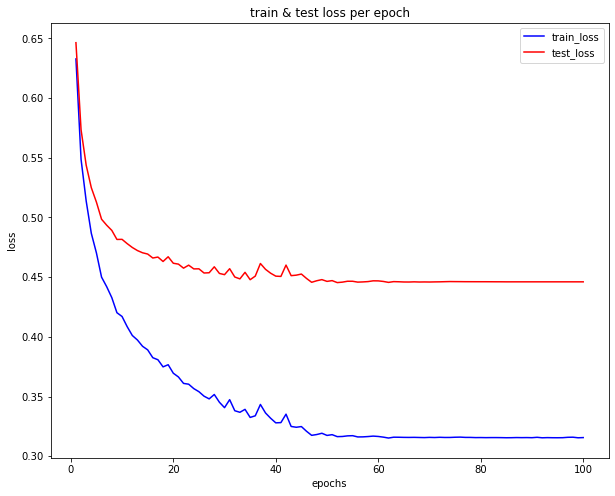

In [14]:
plt.figure(figsize=(10,8))

plt.plot(range(1, 101), train_loss, 'b-', label='train_loss')
plt.plot(range(1, 101), test_loss, 'r-', label='test_loss')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('train & test loss per epoch')
plt.legend()

plt.show()

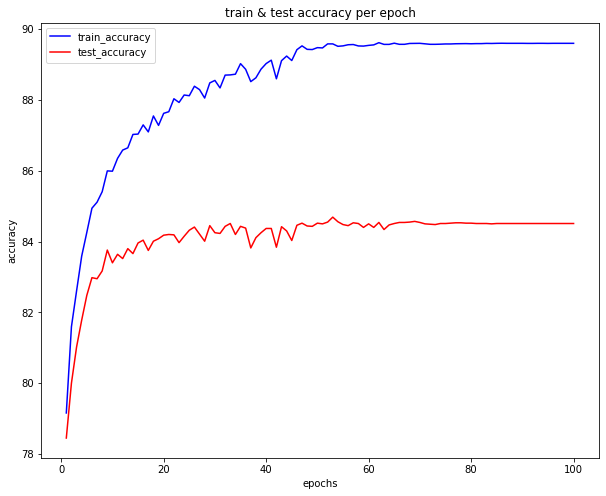

In [15]:
plt.figure(figsize=(10,8))

plt.plot(range(1, 101), train_accuracy, 'b-', label='train_accuracy')
plt.plot(range(1, 101), test_accuracy, 'r-', label='test_accuracy')

plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('train & test accuracy per epoch')
plt.legend()

plt.show()

In [16]:
print(f'Best epoch: {best_epoch}')
print(f'Train: accuracy: {best_train_accuracy:>0.1f}%, avg loss: {best_train_loss:>8f}')
print(f'Test: accuracy: {best_test_accuracy:>0.1f}%, avg loss: {best_test_loss:>8f}')

Best epoch: 53
Train: accuracy: 89.6%, avg loss: 0.316507
Test: accuracy: 84.7%, avg loss: 0.445809


## 5.4 Model metrics

In [17]:
print(f'Train:\n{classification_report(best_train_y, best_train_pred, target_names=target_names)}')
print(f'Test:\n{classification_report(best_test_y, best_test_pred, target_names=target_names)}')

Train:
              precision    recall  f1-score   support

    airplane       0.91      0.92      0.92      5000
  automobile       0.95      0.94      0.95      5000
        bird       0.92      0.81      0.86      5000
         cat       0.83      0.81      0.82      5000
        deer       0.84      0.88      0.86      5000
         dog       0.87      0.85      0.86      5000
        frog       0.89      0.93      0.91      5000
       horse       0.89      0.91      0.90      5000
        ship       0.94      0.95      0.94      5000
       truck       0.93      0.95      0.94      5000

    accuracy                           0.90     50000
   macro avg       0.90      0.90      0.90     50000
weighted avg       0.90      0.90      0.90     50000

Test:
              precision    recall  f1-score   support

    airplane       0.86      0.84      0.85      1000
  automobile       0.90      0.90      0.90      1000
        bird       0.88      0.77      0.82      1000
         ca

<AxesSubplot:>

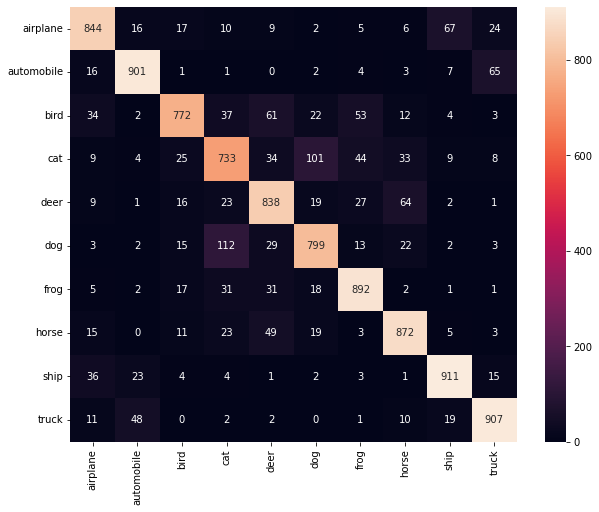

In [18]:
cm = confusion_matrix(best_test_y, best_test_pred)
sns.heatmap(cm, annot=True, fmt='', xticklabels=target_names, yticklabels=target_names, ax=plt.subplots(figsize=(10,8))[1])

## 5.5 Save model

In [19]:
torch.save(best_model_state_dict, '../saved-model/alexnet-weights.pth')